In [290]:
import os
import random
from string import digits, ascii_uppercase, ascii_lowercase
import matplotlib.pyplot as plt
plt.style.use("dark_background")


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import cv2

In [2]:
# config paths for folders

DATA_ROOT = "./mini_data"
TRAIN_FOLDER = "train"
TEST_FOLDER = ""
LABELS_FILE = "labels.csv"

TRAIN_PATH = os.path.join(DATA_ROOT, TRAIN_FOLDER)
TEST_PATH = os.path.join(DATA_ROOT, TEST_FOLDER)
LABELS_PATH = os.path.join(DATA_ROOT, LABELS_FILE)

print(f"{TRAIN_PATH = }")
print(f"{TEST_PATH = }")
print(f"{LABELS_PATH = }")

TRAINSET_SIZE = 0.75
VALIDSET_SIZE = 0.25

IMAGE_SIZE=(225, 225)

TRAIN_PATH = './mini_data\\train'
TEST_PATH = './mini_data\\'
LABELS_PATH = './mini_data\\labels.csv'


In [3]:
labels_df = pd.read_csv(LABELS_PATH)
labels_df.head(5)

,Id,Expected
0,101974.jpg,"Андерссон),"
1,38561.jpg,"""локомо"
2,3346.jpg,Система
3,59072.jpg,"тебя,"
4,148124.jpg,предлагаю


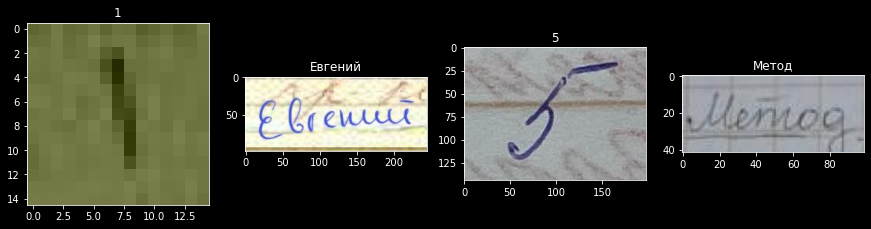

In [4]:
def show_files(num_files=3):
    """
    Show some objects in train dataset
    return: None
    """
    df_samp = labels_df.sample(num_files)
    files = df_samp.Id.values
    texts = df_samp.Expected.values
    
    plt.figure(figsize=(15, 5))
    for i in range(num_files):
        plt.subplot(1, num_files, i+1)
        file_path = os.path.join(TRAIN_PATH, files[i])
        image = cv2.imread(file_path)
        plt.imshow(image)
        plt.title(texts[i])
                  
show_files(4)

In [5]:
def get_alphabet(df):
    """
    Find all characters in train dataset
    return: sorted list of chars
    """
    targets = set()
    for text in df.Expected.values:
        targets.update(text)
        
    return sorted(list(targets))

In [6]:
alphabet = get_alphabet(labels_df)
print(f"length of alphabet: {len(alphabet)}")

length of alphabet: 171


In [7]:
df_train, df_valid = train_test_split(labels_df, test_size=VALIDSET_SIZE, random_state=42)

In [8]:
class RecognitionDatset(Dataset):
    """Constructor for class.
        
        Args:
            - df: dataframe with columns "Id" & "Expected".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
    def __init__(self, df, alphabet=alphabet, transfrom=None):
        self.alphabet = alphabet
        self.transform = transfrom
        self.df = df
        self.image_names, self.texts = self._parse_root()
        
    def join_path(self, x):
        return os.path.join(TRAIN_PATH, x)
    
    def _parse_root(self):
        image_names = self.df["Id"].map(self.join_path).values
        texts = self.df['Expected'].values
        return image_names, texts
    

    def __len__(self):
        return len(self.image_names)
    
    
    def __getitem__(self, idx):
        """
        Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[idx]).astype(np.float32)
        text = self.texts[idx]
        seq = self.text2seq(text)
        seq_len = len(seq)
        output = {"image": image, "seq": seq, "seq_len": seq_len, "text": text}
        
        if self.transform:
            output = self.transform(output)
            
        return output
    
    
    def text2seq(self, text):
        """
        Encode text to sequence of integers.
        Args:
            - String of text.       
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        idx_list = [self.alphabet.index(item) for item in text]
        return idx_list
        
        


In [91]:
class Resize(object):
    def __init__(self, size=IMAGE_SIZE):
        self.size = size

    def __call__(self, item):
        """
        Apply resizing.
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text". 
        Returns: 
            Dict with image resized to self.size.
        """     
        # YOUR CODE HERE
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)/255.
        # END OF YOUR CODE
        
        return item

In [92]:
IMAGE_SIZE = (225, 225)

In [93]:
train_transform = Resize(IMAGE_SIZE)
valid_transform = Resize(IMAGE_SIZE)

trainset = RecognitionDatset(df_train, alphabet, transfrom=train_transform)
validset = RecognitionDatset(df_valid, alphabet, transfrom=valid_transform)

In [114]:
def collate_fn(batch):
    """
    Function for torch.utils.data.Dataloader for batch collecting.
    Args:
        - batch: List of dataset __getitem__ return values (dicts).      
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [115]:
xs = [trainset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [116]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 300, 300])
Seq: torch.Size([25])
Seq: tensor([ 24,  21,  24,  18, 100, 145, 148, 144, 144, 129,  99,   0, 139, 143,
        147, 143, 145, 143, 141, 114,  97, 109,  97, 113, 124],
       dtype=torch.int32)
Seq_len: tensor([4, 6, 9, 6], dtype=torch.int32)
Text: ['8582', 'Группа', 'В котором', 'САМАРЫ']


In [117]:
class AffineAugmenter(object):
    def __init__(self, min_scale=0.99, max_scale=1.01, max_offset=0.1, max_angle = 20, p=0.5):
        self._min_scale = min_scale
        self._max_scale = max_scale
        self._max_offset = max_offset
        self.max_angle = max_angle
        self.p = p
        self.name = "AffineAugmenter"
        
    def rotate(self, sample):
        #print(sample)
        image = sample['image']

        #image = image.numpy()  # torch -> Numpy.
        h, w, c = image.shape
        assert c == 3
        
        angle = random.randint(-self.max_angle, self.max_angle)
        scale = self._min_scale + random.random() * (self._max_scale - self._min_scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        
        # Ваш код, который преобразует изображение используя угол angle,
        # масштаб scale и смещение (x_offset, y_offset). Фон предлагается закрасить серым цветом.        
        # Начало вашего кода.
        
        transform = cv2.getRotationMatrix2D((w // 2, h // 2), angle, scale)
         
         # input -> Center of rotation, Angle of Rotation,  scaling factor which 
        transform[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, transform, (w, h), borderValue=(128, 128, 128))
        new_image = np.clip(new_image, 0, 255).astype(np.uint8)
        sample['image'] = new_image
        
        return sample
        
    def __call__(self, sample):
        
        sample = self.rotate(sample)
        
        return sample
    
class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast
        self.name = "BrightnessContrastAugmenter"
    
    def __call__(self, sample):
        
        image = sample['image']
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        
        # Ваш код, который применяет яркость brightness и контраст contrast.
        
        new_image = image.astype(np.float32)
        new_image = (new_image - 128) * contrast + 128
        new_image = new_image + brightness * 255
        new_image = np.clip(new_image, 0, 255).astype(np.uint8)
        
        sample['image'] = new_image
        
        
        return sample
    
class BlurAugmenter(object):
    def __init__(self, kernels=[3, 5, 7]):
        self.kernels = kernels
        self.name = "BlurAugmenter"
    
    def __call__(self, sample):
        image = sample['image']
        kernel = random.choice(self.kernels)
        image = image.astype(np.float32) 
        
        new_image = cv2.GaussianBlur(image, (kernel, kernel), kernel // 2)
        new_image = np.clip(new_image, 0, 255).astype(np.uint8)
        sample['image'] = new_image
        return sample

In [118]:
class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)
        
    def __call__(self, sample):    
        rand_aug = random.choice(self._augmenters)
        #print(rand_aug.name)
        rand_aug_image = rand_aug(sample)
            
        return sample

In [119]:
class Trivial(object):
    def __init__(self):
        self.name = "trivial"
        pass
    
    def __call__(self, sample):
        image = sample['image']
        new_image = np.clip(image, 0, 255).astype(np.uint8)
        sample['image'] = new_image
        return sample

In [120]:
train_augmenter = RandomAugmentation(AffineAugmenter(max_angle=90, p=0.99),
                               BrightnessContrastAugmenter(brightness=0.3, contrast=0.3),
                               BlurAugmenter(),
                               Trivial(),
                              )

valid_augmenter = RandomAugmentation(Trivial())

In [230]:
IMAGE_SIZE = (320, 64)

In [231]:
train_transforms = transforms.Compose([#  
         train_augmenter,
         Resize(IMAGE_SIZE),
    ])

valid_transforms = transforms.Compose([#
         valid_augmenter,
         Resize(IMAGE_SIZE),
    ])

In [232]:
trainset = RecognitionDatset(df_train, alphabet, transfrom=train_transforms)
valid = RecognitionDatset(df_train, alphabet, transfrom=valid_transforms)

In [362]:
for i in range(len(trainset)):
    item = trainset[i]
    break

In [363]:
item

{'image': array([[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.01568627, 0.00392157, 0.        ],
         [0.01568627, 0.00392157

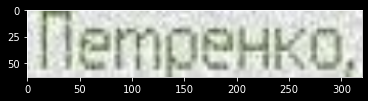

In [289]:
plt.imshow(trainset[6]['image'])
plt.show()

In [340]:
IMAGE_SIZE

(320, 64)

In [341]:
model_type = 'resnext50_32x4d'
resnet = getattr(models, model_type)(pretrained=False)
cnn = nn.Sequential(*list(resnet.children())[:-2])
inp_image = torch.rand((1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
cnn_out = cnn(inp_image)
shape = cnn_out.shape
resize_facor = int(IMAGE_SIZE[0]/shape[-2]), int(IMAGE_SIZE[1]/shape[-1])
print(f"Input image size: {inp_image.shape}")
print(f"Cnn output size: {shape}")
print(f"{resize_facor=}")

Input image size: torch.Size([1, 3, 320, 64])
Cnn output size: torch.Size([1, 2048, 10, 2])
resize_facor=(32, 32)


In [342]:
IMAGE_SIZE[0] // resize_facor[0]

10

In [343]:
pool = nn.AvgPool2d(kernel_size=(IMAGE_SIZE[0] // resize_facor[0], 1))
pool_out = pool(cnn_out)
pool_out.shape

torch.Size([1, 2048, 1, 2])

In [344]:
pool_out = pool_out.permute(0, 3, 2, 1).contiguous()
pool_out.shape

torch.Size([1, 2, 1, 2048])

In [338]:
output_len = 64
proj = nn.Conv2d(2, output_len, kernel_size=1)
proj_out = proj(pool_out)
proj_out.shape


torch.Size([1, 64, 1, 2048])

In [339]:
proj_out = proj_out.permute(0, 2, 3, 1).contiguous()
proj_out.shape

torch.Size([1, 1, 2048, 64])

In [356]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, cnn_model_name = "resnext50_32x4d", input_size=IMAGE_SIZE, output_len=64):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, cnn_model_name)(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        test_image = torch.rand((1, 3, h, w))
        _, _, out_h, out_w = self.cnn(inp_image).shape
        
        self.pool = nn.AvgPool2d(kernel_size=(out_h, 1))        
        self.proj = nn.Conv2d(out_w, output_len, kernel_size=1)
        
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
    
    def forward(self, x):
        # Apply conv layers
        # x: (batch_size, num_channels, height, width)
        features = self.cnn(x)
        # (batch_size, out_channels, height//resize_h, width//resize_w)
        
        # Pool to make height == 1
        features = self.pool(features)
        # (batch_size, out_channels, 1, width//resize_w)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        # (batch_size, 1, out_channels, output_len)
        
        return features

In [370]:
extractor  = FeatureExtractor()
extractor_out = extractor(inp_image)
extractor_out.shape

torch.Size([1, 1, 2048, 64])

In [366]:
class SequencePredictor(nn.Module):
    
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 num_layers, 
                 num_classes, 
                 dropout=0.3, 
                 bidirectional=False):
        
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout,
                          bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1) # (batch_size, height, width)
        x = x.permute(2, 0, 1) # (width, batch_size, height)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        # x = (batch_size, height, width)
        x = self._reshape_features(x)  # (width, batch_size, height)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [367]:
sequence_predictor = SequencePredictor(input_size=2048, 
                                       hidden_size=512, 
                                       num_layers=2, 
                                       num_classes=len(alphabet) + 1)

In [371]:
sequence_predictor(extractor_out).shape

torch.Size([64, 1, 172])

In [373]:
class CRNN(nn.Module):
    
    def __init__(self, alphabet=alphabet,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence